## 📚 **Importing Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import random,os
from PIL import Image

from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential
from keras.layers import Conv2D,GlobalAveragePooling2D ,MaxPooling2D, Dropout, Flatten, Dense,Input, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

In [2]:
path = "/kaggle/input/binary-classification-data-aptos-and-messidor/Train Images_new"

In [3]:
folders = os.listdir(path)
folder_path = os.path.join(path, folders[0])

files = os.listdir(folder_path)
files = files[1:]

Images = []
Labels = []

for i in range(len(files)):
    file_path = os.path.join(folder_path, files[i])
    
    for img in os.listdir(file_path):
        image_path = os.path.joAn(file_path ,img)
            
        Images.append(image_path)
        if file_path.split('_')[-1] == '0':
            Labels.append('0')
        else:
            Labels.append('1')


df = pd.DataFrame({'Images': Images, 'Labels': Labels})
df.head()


,Images,Labels
0,/kaggle/input/binary-classification-data-aptos...,1
1,/kaggle/input/binary-classification-data-aptos...,1
2,/kaggle/input/binary-classification-data-aptos...,1
3,/kaggle/input/binary-classification-data-aptos...,1
4,/kaggle/input/binary-classification-data-aptos...,1


In [4]:
df['Labels'].value_counts()

Labels
1    7425
0    7220
Name: count, dtype: int64

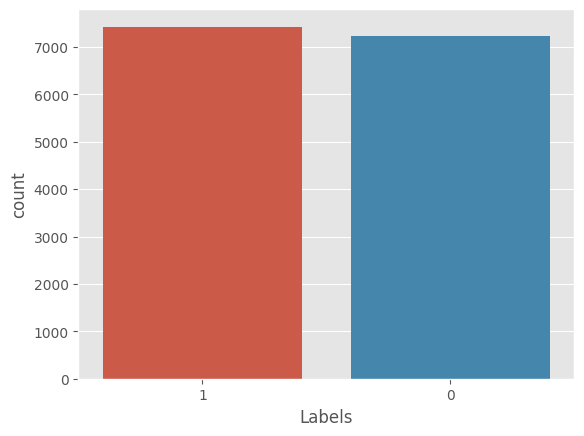

In [5]:
sns.countplot(data = df , x = 'Labels')
plt.show()

(224, 224, 3)


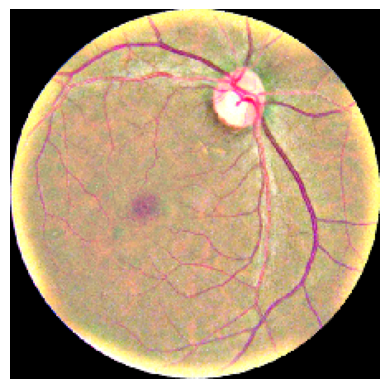

In [7]:
Image = random.choice(df['Images'])
image = load_img(Image,target_size=(224, 224))
plt.imshow(image)
plt.axis('off')
image_array = np.array(image)  
print(image_array.shape)

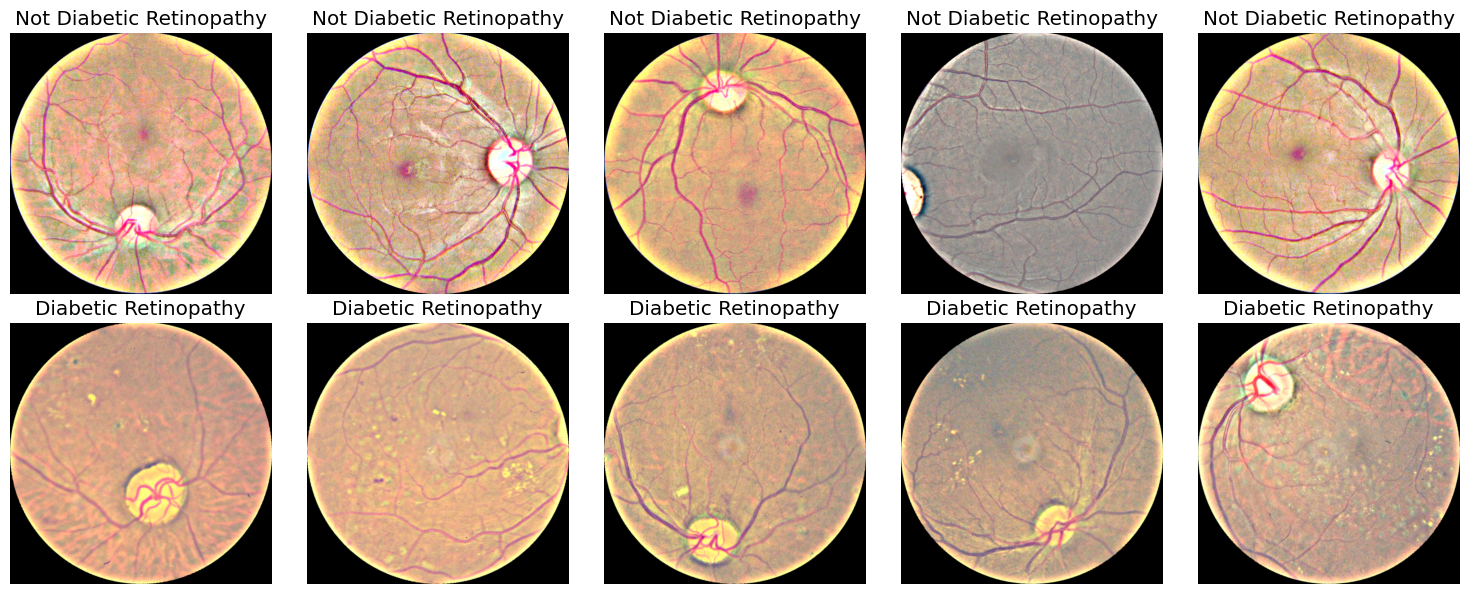

In [8]:
class_0_path = df[df['Labels'] == '0'].reset_index(drop = True)
class_1_path = df[df['Labels'] == '1'].reset_index(drop = True)


fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    if i < 5:
        Image = random.choice(class_0_path['Images'])
        image = load_img(Image)
        ax.set_title("Not Diabetic Retinopathy")
    else:
        Image = random.choice(class_1_path['Images'])
        image = load_img(Image)
        ax.set_title("Diabetic Retinopathy")

    ax.imshow(image)
    ax.axis('off')  

plt.tight_layout()
plt.show()


### `Variables`

In [9]:
img_size = (224, 224)
batch_size = 32

In [10]:
train_df , validation_df = train_test_split(df , random_state = 42 , test_size=0.1 , shuffle=True)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1  # 10% for validation
)

train_gen = datagen.flow_from_dataframe(
    train_df,
    x_col = 'Images',
    y_col = 'Labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='training'
)

val_gen = datagen.flow_from_dataframe(
    validation_df,
    x_col = 'Images',
    y_col = 'Labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation'
)

Found 11862 validated image filenames belonging to 2 classes.
Found 146 validated image filenames belonging to 2 classes.


In [12]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(learning_rate=3e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')

In [14]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[early_stopping]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724590937.129629    1091 service.cc:145] XLA service 0x7e2790005500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724590937.129686    1091 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  1/371 ━━━━━━━━━━━━━━━━━━━━ 9:14:46 90s/step - accuracy: 0.5938 - loss: 0.7379

I0000 00:00:1724590985.364108    1091 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


371/371 ━━━━━━━━━━━━━━━━━━━━ 361s 731ms/step - accuracy: 0.9454 - loss: 0.1488 - val_accuracy: 0.5068 - val_loss: 0.7404
Epoch 2/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 130s 345ms/step - accuracy: 0.9879 - loss: 0.0350 - val_accuracy: 0.8973 - val_loss: 0.2323
Epoch 3/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 132s 348ms/step - accuracy: 0.9958 - loss: 0.0134 - val_accuracy: 0.9795 - val_loss: 0.0779
Epoch 4/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 130s 343ms/step - accuracy: 0.9959 - loss: 0.0125 - val_accuracy: 0.9726 - val_loss: 0.1156
Epoch 5/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 142s 343ms/step - accuracy: 0.9961 - loss: 0.0118 - val_accuracy: 0.9795 - val_loss: 0.0899
Epoch 6/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 128s 338ms/step - accuracy: 0.9963 - loss: 0.0114 - val_accuracy: 0.9863 - val_loss: 0.0754
Epoch 7/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 130s 344ms/step - accuracy: 0.9962 - loss: 0.0118 - val_accuracy: 0.9658 - val_loss: 0.1946
Epoch 8/20
371/371 ━━━━━━━━━━━━━━━━━━━━ 130s 344ms/step - accuracy: 0.9965 - loss: 0.00

In [15]:
model.evaluate(val_gen, verbose=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.9841 - loss: 0.0288


[0.02648896351456642, 0.9863013625144958]

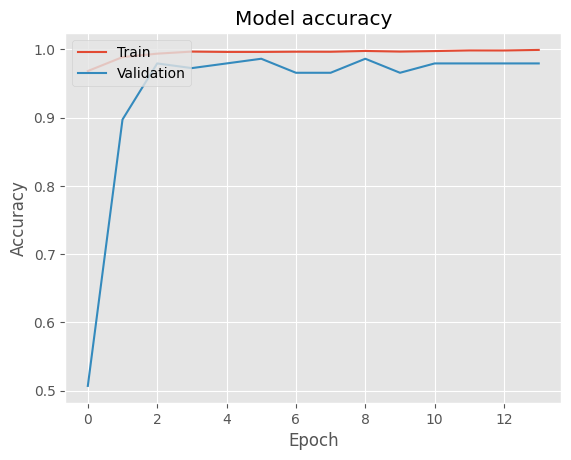

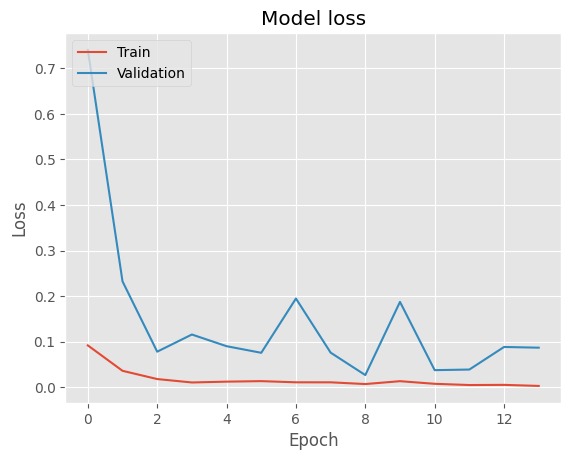

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [21]:
test_path = "/kaggle/input/binary-classification-data-aptos-and-messidor/Test Images_new"

In [23]:
folders = os.listdir(test_path)
folder_path = os.path.join(test_path, folders[0])

files = os.listdir(folder_path)
files = files[1:]

Images = []
Labels = []

for i in range(len(files)):
    file_path = os.path.join(folder_path, files[i])
    
    for img in os.listdir(file_path):
        image_path = os.path.join(file_path ,img)
            
        Images.append(image_path)
        if file_path.split('_')[-1] == '0':
            Labels.append('0')
        else:
            Labels.append('1')


df_test = pd.DataFrame({'Images': Images, 'Labels': Labels})
df_test.head()


,Images,Labels
0,/kaggle/input/binary-classification-data-aptos...,1
1,/kaggle/input/binary-classification-data-aptos...,1
2,/kaggle/input/binary-classification-data-aptos...,1
3,/kaggle/input/binary-classification-data-aptos...,1
4,/kaggle/input/binary-classification-data-aptos...,1


In [24]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_gen = test_datagen.flow_from_dataframe(
    df_test,
    x_col='Images',
    y_col='Labels',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Ensure test data is not shuffled
)

Found 3665 validated image filenames belonging to 2 classes.


In [25]:
test_loss, test_accuracy = model.evaluate(test_gen, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 74s 645ms/step - accuracy: 0.9769 - loss: 0.0959
Test Loss: 0.11085166782140732
Test Accuracy: 0.9735334515571594


In [34]:
predictions = model.predict(test_gen, verbose=1)
predictions = np.argmax(predictions , axis = 1)

predictions



115/115 ━━━━━━━━━━━━━━━━━━━━ 38s 334ms/step


array([1, 1, 1, ..., 0, 0, 0])

In [39]:
y_true = df_test['Labels']

In [40]:
data = pd.DataFrame({'Actual_Value' :y_true , 'Predicted_value':predictions})
data.head()

,Actual_Value,Predicted_value
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


In [45]:
data['Actual_Value'] = data['Actual_Value'].astype('int64')

In [54]:
(data[data['Actual_Value'] == data['Predicted_value']].shape[0])/data.shape[0]

0.9735334242837653